## Lab 9c: Markov Decision Processes, Value and Policy Iteration

### Markov Decision Processes (MDPs)
In an MDP, an agent receives a reward or penalty for each decision. MDPs consist of the tuple $\left(\mathcal{S}, \mathcal{A}, R_{a}\left(s, s^{\prime}\right), T_{a}\left(s,s^{\prime}\right), \gamma\right)$:

* The state space $\mathcal{S}$ is the set of all possible states $s$ that a system can exist in.
* The action space $\mathcal{A}$ is the set of all possible actions $a$ that are available to the agent, where $\mathcal{A}_{s} \subseteq \mathcal{A}$ is the subset of the action space $\mathcal{A}$ that is accessible from state $s$.
* An reward $R_{a}\left(s, s^{\prime}\right)$ is received after transitioning from $s\rightarrow{s}^{\prime}$ due to action $a$. 
* The state transition model $T_{a}\left(s,s^{\prime}\right) = P(s_{t+1} = s^{\prime}~|~s_{t}=s,a_{t} = a)$ denotes the probability that action $a$ in state $s$ at time $t$ will result in state $s^{\prime}$ at time $t+1$
* The quantity $\gamma$ is a discount factor used to weigh the future expected utility.

Finally, a policy function $\pi$ is the mapping from states $s\in\mathcal{S}$ to actions $a\in\mathcal{A}$ used by the agent to solve a decision task, i.e., $\pi(s) = a$.

### Value Iteration
_Value iteration_ iteratively computes the optimal value function $U^{*}(s)$ using the _Bellman backup_ operation:

$$
\begin{equation*}
U_{k+1}(s) = \underset{a\in\mathcal{A}}{\max}\left(R(s,a) + \gamma\cdot\sum_{s^{\prime}\in\mathcal{S}}T(s^{\prime}\,\vert\,s,a)\cdot{U}_{k}(s^{\prime})\right)
\end{equation*}
$$

As $k\rightarrow\infty$ the value function $U_{k}(s)$ converges to the optimal value function $U^{\star}(s)$. The optimal policy $\pi^{\star}(s)$ can be extracted from the $Q(s,a)$-function:

$$
\begin{equation*}
Q^{\star}(s,a) = R(s,a) + \gamma\times{\text{sum}([T(s,s^{\prime},a)\times{U^{\star}}(s^{\prime})\,\,\text{for}\,s^{\prime} \in\mathcal{S}])}
\end{equation*}
$$

by selecting the action $a$ such that:

$$
\begin{equation*}
\pi^{\star}(s) = \underset{a\in\mathcal{A}}{\arg\max}\,Q^{\star}(s,a)
\end{equation*}
$$

### Learning objectives
Suppose you have a [roomba](https://www.irobot.com) that has finished cleaning the floor in your kitchen and needs to return to its charging station. However, between your kitchen and the `charging station` (home base and safety), there are one or more `lava pits` (destruction for the [roomba](https://www.irobot.com)). This is an example of a two-dimensional grid-world navigational decision task. 

`Lab 9c` will familiarize students with using `value iteration` for solving a two-dimensional grid-world navigation task. In particular, we will:

* __Task 1__: Setup a $n_{r}\times{n}_{c}$ grid, encoded this model as an instance of the `MyRectangularGridWorldModel` type
    * `TODO`: Inspect the data inside our grid world model, understand what each describes
* __Task 2__: Use our `MyRectangularGridWorldModel` instance and generate the components of the `MDP`, namely, the return function (or array) `R(s, a)`, and the model of the physics of the world in the transition function (or array) `T(s, s′, a)`.
* __Task 3__: Use a `value iteration` method to estimate the optimal value function $U^{\star}(s)$
    * `TODO`: Extract the `action-value function` or $Q(s, a)$ from the optimal optimal value function $U^{\star}(s)$ 
    * `TODO`: Compute the optimal navigation policy $\pi^{\star}(s)$ from $Q(s,a)$
    * `TODO`: Visualize the optimal policy

## Setup
The computations in this lab (or example) are enabled by the [VLDecisionsPackage.jl](https://github.com/varnerlab/VLDecisionsPackage.jl.git) and several external `Julia` packages. To load the required packages and any custom codes the teaching team has developed to work with these packages, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-13/L13c`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-13/L13c/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-13/L13c/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-13/L13c/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-13/L13c/Manifest.toml`


## Task 1: Build the world model
We encoded the `rectangular grid world` using the `MyRectangularGridWorldModel` model, which we construct using a `build(...)` method. Let's setup the data for the world, setup the states, actions, rewards and then construct the world model. 
* First, set values for the `number_of_rows` and `number_of_cols` variables, the `nactions` that are avialble to the agent and the `discount factor` $\gamma$. 
* Then, we'll compute the number of states, and setup the state set $\mathcal{S}$ and the action set $\mathcal{A}$

In [2]:
number_of_rows = 5
number_of_cols = 5
nactions = 4;
γ = 0.95;
nstates = (number_of_rows*number_of_cols);
𝒮 = range(1,stop=nstates,step=1) |> collect;
𝒜 = range(1,stop=nactions,step=1) |> collect;

In [3]:
𝒜

4-element Vector{Int64}:
 1
 2
 3
 4

Next, we'll set up a description of the rewards, the `rewards::Dict{Tuple{Int,Int}, Float64}` dictionary, which maps the $(x,y)$-coordinates to a reward value. We only need to put `non-default` reward values in the reward dictionary (we'll add default values to the other locations later). Lastly, let's put the locations on the grid that are `absorbing`, meaning the charging station or lava pits in your living room:

In [4]:
# setup rewards -
lava_reward = -1000.0;
charging_reward = 100.0

rewards = Dict{Tuple{Int,Int}, Float64}()
rewards[(1,2)] = lava_reward # lava in the (1,2) square 
rewards[(2,2)] = lava_reward # lava in the (2,2) square 
rewards[(2,3)] = lava_reward # lava in the (2,3) square 
rewards[(4,5)] = lava_reward # lava in the (4,4) square
rewards[(4,3)] = charging_reward   # charging station square

# setup set of absorbing states -
absorbing_state_set = Set{Tuple{Int,Int}}()
for (k,v) ∈ rewards
    push!(absorbing_state_set, k);   
end

# setup soft walls (constraints) -
soft_wall_set = Set{Tuple{Int,Int}}();

Finally, we can build an instance of the `MyRectangularGridWorldModel` type, which models the grid world. We save this instance in the `world` variable
* We must pass in the number of rows `nrows`, number of cols `ncols`, and our initial reward description in the `rewards` field into the `build(...)` method

In [5]:
world = build(MyRectangularGridWorldModel, 
    (nrows = number_of_rows, ncols = number_of_cols, rewards = rewards));

#### Questions
* `TODO`: Inspect the data inside our grid world model, understand what each describes

In [6]:
world.coordinates

Dict{Int64, Tuple{Int64, Int64}} with 25 entries:
  5  => (1, 5)
  16 => (4, 1)
  20 => (4, 5)
  12 => (3, 2)
  24 => (5, 4)
  8  => (2, 3)
  17 => (4, 2)
  1  => (1, 1)
  19 => (4, 4)
  22 => (5, 2)
  23 => (5, 3)
  6  => (2, 1)
  11 => (3, 1)
  9  => (2, 4)
  14 => (3, 4)
  3  => (1, 3)
  7  => (2, 2)
  25 => (5, 5)
  4  => (1, 4)
  13 => (3, 3)
  15 => (3, 5)
  2  => (1, 2)
  10 => (2, 5)
  18 => (4, 3)
  21 => (5, 1)

In [29]:
world.states

Dict{Tuple{Int64, Int64}, Int64} with 25 entries:
  (4, 5) => 20
  (1, 2) => 2
  (3, 1) => 11
  (2, 5) => 10
  (1, 3) => 3
  (1, 4) => 4
  (5, 5) => 25
  (3, 2) => 12
  (3, 3) => 13
  (4, 1) => 16
  (2, 1) => 6
  (3, 4) => 14
  (1, 5) => 5
  (4, 2) => 17
  (5, 1) => 21
  (2, 2) => 7
  (4, 3) => 18
  (2, 3) => 8
  (3, 5) => 15
  (4, 4) => 19
  (2, 4) => 9
  (1, 1) => 1
  (5, 2) => 22
  (5, 3) => 23
  (5, 4) => 24

## Task 2: Generate the components of the MDP problem
The MDP problem requires the return function (or array) `R(s, a)`, and the transition function (or array) `T(s, s′, a)`. Let's construct these from our grid world model instance, starting with the reward function `R(s, a)`:

### Rewards $R(s,a)$
We'll encode the reward function as a $\dim\mathcal{S}\times\dim\mathcal{A}$ array, which holds the reward values for being in state $s\in\mathcal{S}$ and taking action $a\in\mathcal{A}$. After initializing the `R`-array and filling it with zeros, we'll populate the non-zero values of $R(s, a)$ using nested `for` loops. During each iteration of the `outer` loop, we'll:
* Select a state `s`, an action `a`, and a move `Δ`
* We'll then compute the new position resulting from implementing action `a` from the current position and store this in the `new_position` variable. * If the `new_position`$\in\mathcal{S}$ is in our initial `rewards` dictionary (the charging station or a lava pit), we use that reward value from the `rewards` dictionary. If we are still in the world but not in a special location, we set the reward to `-1`.
* Finally, if `new_position`$\notin\mathcal{S}$, i.e., the `new_position` is a space outside the grid, we set a penalty of `-50000.0`.

In [8]:
R = zeros(nstates, nactions);
fill!(R, 0.0)
for s ∈ 𝒮
    for a ∈ 𝒜
        
        Δ = world.moves[a];
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        if (haskey(world.states, new_position) == true)
            if (haskey(rewards, new_position) == true)
                R[s,a] = rewards[new_position];
            else
                R[s,a] = -1.0;
            end
        else
            R[s,a] = -50000.0; # we are off the grid, big negative penalty
        end
    end
end
R

25×4 Matrix{Float64}:
 -50000.0      -1.0  -50000.0   -1000.0
 -50000.0   -1000.0      -1.0      -1.0
 -50000.0   -1000.0   -1000.0      -1.0
 -50000.0      -1.0      -1.0      -1.0
 -50000.0      -1.0      -1.0  -50000.0
     -1.0      -1.0  -50000.0   -1000.0
  -1000.0      -1.0      -1.0   -1000.0
     -1.0      -1.0   -1000.0      -1.0
     -1.0      -1.0   -1000.0      -1.0
     -1.0      -1.0      -1.0  -50000.0
     -1.0      -1.0  -50000.0      -1.0
  -1000.0      -1.0      -1.0      -1.0
  -1000.0     100.0      -1.0      -1.0
     -1.0      -1.0      -1.0      -1.0
     -1.0   -1000.0      -1.0  -50000.0
     -1.0      -1.0  -50000.0      -1.0
     -1.0      -1.0      -1.0     100.0
     -1.0      -1.0      -1.0      -1.0
     -1.0      -1.0     100.0   -1000.0
     -1.0      -1.0      -1.0  -50000.0
     -1.0  -50000.0  -50000.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
    100.0  -50000.0      -1.0      -1.0
     -1.0  -50000.0      -1.0      -1.0
  -1000.0  -50000.

### Transition $T(s, s^{\prime},a)$
Next, build the transition function $T(s,s^{\prime},a)$. We'll encode this as a $\dim\mathcal{S}\times\dim\mathcal{S}\times\dim\mathcal{A}$ [multidimension array](https://docs.julialang.org/en/v1/manual/arrays/) and populate it using nested `for` loops. 

* The `outer` loop we will iterate over actions. For every $a\in\mathcal{A}$ will get the move associated with that action and store it in the `Δ`
* In the `inner` loop, we will iterate over states $s\in\mathcal{S}$. We compute a `new_position` resulting from implementing action $a$ and check if `new_position`$\in\mathcal{S}$. If `new_position` is in the world, and `current_position` is _not_ an `absorbing state` we set $s^{\prime}\leftarrow$`world.states[new_position]`, and `T[s, s′,  a] = 1.0`
* However, if the `new_position` is outside of the grid (or we are jumping from an `absorbing` state), we set `T[s, s,  a] = 1.0`, i.e., the probability that we stay in `s` if we take action `a` is `1.0`.

In [9]:
T = Array{Float64,3}(undef, nstates, nstates, nactions);
fill!(T, 0.0)
for a ∈ 𝒜
    
    Δ = world.moves[a];
    
    for s ∈ 𝒮
        current_position = world.coordinates[s]
        new_position =  current_position .+ Δ
        if (haskey(world.states, new_position) == true && 
                in(current_position, absorbing_state_set) == false)
            s′ = world.states[new_position];
            T[s, s′,  a] = 1.0
        else
            T[s, s,  a] = 1.0
        end
    end
end

In [10]:
sum(T[24,:,1])

1.0

Finally, we construct an instance of the `MyMDPProblemModel` which encodes the data required to solve the MDP problem.
* We must pass the states `𝒮`, the actions `𝒜`, the transition matrix `T`, the reward matrix `R`, and the discount factor `γ` into the `build(...)` method. We store the MDP model in the `m` variable:

In [11]:
m = build(MyMDPProblemModel, (𝒮 = 𝒮, 𝒜 = 𝒜, T = T, R = R, γ = γ));

In [12]:
m.𝒮

25-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25

## Task 3: Estimate the optimal value function $U^{\star}(s)$
Let's explore value iteration by first constructing an instance of the `MyValueIterationModel` type, which takes the maximum number of iterations as a parameter. Save this in the `value_iteration_model` variable:

In [13]:
value_iteration_model = MyValueIterationModel(1000);

Next, we call the `solve(...)` method by passing the `value_iteration_model` instance and our MDP model `m::MyMDPProblemModel` as arguments. The `solve(...)` method iteratively computes the value function $U^{\star}(s)$, by calling the `backup(...)` function, which in turn calls the `lookahead(...)` function:
* The `solve(...)` method iteratively computes the optimal value function $U^{\star}(s)$ and returns it in an instance of the `MyValueFunctionPolicy` type. 

In [14]:
solution = solve(value_iteration_model, m);

In [15]:
solution.U

25-element Vector{Float64}:
  62.26513125000004
 -19.99999999999995
  62.26513125000004
  66.59487500000004
  62.26513125000004
  66.59487500000004
 -19.99999999999995
 -19.99999999999995
  71.15250000000005
  66.59487500000004
  71.15250000000005
  75.95000000000005
  81.00000000000006
  75.95000000000005
  71.15250000000005
  75.95000000000005
  81.00000000000006
 -19.99999999999995
  81.00000000000006
 -19.99999999999995
  71.15250000000005
  75.95000000000005
  81.00000000000006
  75.95000000000005
  71.15250000000005

### Questions
* `TODO`: Extract the `action-value function` or $Q(s, a)$ from the optimal optimal value function $U^{\star}(s)$. We can do this using the `Q(...)` function, which takes `m` and the `solution::MyValueFunctionPolicy`
    
    ```julia
    function Q(p::MyMDPProblemModel, U::Array{Float64,1})::Array{Float64,2}

        # grab stuff from the problem
        𝒮, T, R, γ = p.𝒮, p.T, p.R, p.γ;

        # initialize -
        Q_array = Array{Float64,2}(undef, length(𝒮), length(𝒜))

        for s ∈ 1:length(𝒮)
            for a ∈ 1:length(𝒜)
                Q_array[s,a] = R[s,a] + γ*sum([T[s, s′,a]*U[s′] for s′ in 𝒮]);
            end
        end

        return Q_array
    end
    ```

In [16]:
my_Q = Q(m, solution.U)

25×4 Matrix{Float64}:
 -49940.8         62.2651  -49940.8      -1019.0
 -50019.0      -1019.0        -20.0        -20.0
 -49940.8      -1019.0      -1019.0         62.2651
 -49936.7         66.5949      58.1519      58.1519
 -49940.8         62.2651      62.2651  -49940.8
     58.1519      66.5949  -49936.7      -1019.0
  -1019.0        -20.0        -20.0      -1019.0
    -20.0        -20.0      -1019.0        -20.0
     62.2651      71.1525   -1019.0         62.2651
     58.1519      66.5949      66.5949  -49936.7
     62.2651      71.1525  -49932.4         71.1525
  -1019.0         75.95        66.5949      75.95
  -1019.0         81.0         71.1525      71.1525
     66.5949      75.95        75.95        66.5949
     62.2651   -1019.0         71.1525  -49932.4
     66.5949      66.5949  -49927.8         75.95
     71.1525      71.1525      71.1525      81.0
    -20.0        -20.0        -20.0        -20.0
     71.1525      71.1525      81.0      -1019.0
    -20.0        -20.0     

 * `TODO`: Compute the optimal navigation policy $\pi^{\star}(s)$ from $Q(s,a)$. We can do this using the `policy(...)` function:
 ```julia
 function policy(Q_array::Array{Float64,2})::Array{Int64,1}

    # get the dimension -
    (NR, _) = size(Q_array);

    # initialize some storage -
    π_array = Array{Int64,1}(undef, NR)
    for s ∈ 1:NR
        π_array[s] = argmax(Q_array[s,:]);
    end

    # return -
    return π_array;
end
 ```

In [17]:
my_π = policy(my_Q)

25-element Vector{Int64}:
 2
 3
 4
 2
 2
 2
 2
 1
 2
 2
 2
 2
 2
 2
 3
 4
 4
 1
 3
 1
 1
 1
 1
 1
 3

 * `TODO`: Visualize the optimal policy

In [18]:
move_arrows = Dict{Int,Any}();
move_arrows[1] = "←"
move_arrows[2] = "→"
move_arrows[3] = "↓"
move_arrows[4] = "↑"
move_arrows[5] = "∅";

In [19]:
for s ∈ 𝒮
    a = my_π[s];
    Δ = world.moves[a];
    current_position = world.coordinates[s]
    new_position =  current_position .+ Δ
    
    if (in(current_position, absorbing_state_set) == true)
        println("$(current_position) $(move_arrows[5])")
    else
        println("$(current_position) $(move_arrows[a]) $(new_position)")
    end
end

(1, 1) → (2, 1)
(1, 2) ∅
(1, 3) ↑ (1, 4)
(1, 4) → (2, 4)
(1, 5) → (2, 5)
(2, 1) → (3, 1)
(2, 2) ∅
(2, 3) ∅
(2, 4) → (3, 4)
(2, 5) → (3, 5)
(3, 1) → (4, 1)
(3, 2) → (4, 2)
(3, 3) → (4, 3)
(3, 4) → (4, 4)
(3, 5) ↓ (3, 4)
(4, 1) ↑ (4, 2)
(4, 2) ↑ (4, 3)
(4, 3) ∅
(4, 4) ↓ (4, 3)
(4, 5) ∅
(5, 1) ← (4, 1)
(5, 2) ← (4, 2)
(5, 3) ← (4, 3)
(5, 4) ← (4, 4)
(5, 5) ↓ (5, 4)


In [38]:
𝒮

25-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20
 21
 22
 23
 24
 25

(s, s_next) = ((1, 1), (2, 1))
(s, s_next) = ((2, 1), (3, 1))
(s, s_next) = ((3, 1), (4, 1))
(s, s_next) = ((4, 1), (4, 2))
(s, s_next) = ((4, 2), (4, 3))


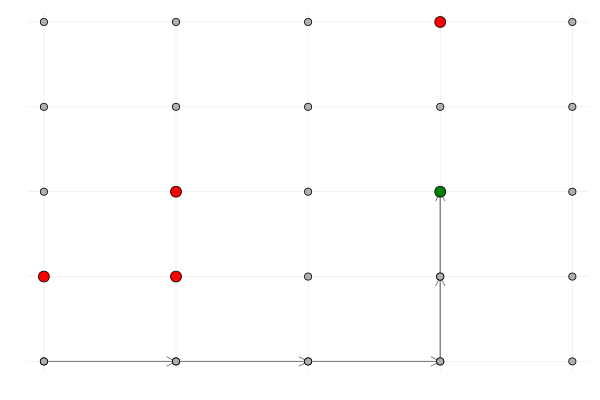

In [42]:
# draw the path -
p = plot();
s = (1,1);

visited_sites = Set{Tuple{Int,Int}}();
# push!(visited_sites, initial_site);

while (in(s, absorbing_state_set) == false)

    state = world.states[s];
    a = my_π[state];
    Δ = world.moves[a];
    s_next =  s .+ Δ

    @show s, s_next

    scatter!([s[1]],[s[2]], label="", showaxis=:false, msc=:black, c=:blue)
    plot!([s[1], s_next[1]],[s[2], s_next[2]], label="", arrow=true, lw=1, c=:gray)
    
    if (haskey(world.states, s_next) == true)
        push!(visited_sites, s_next);
        s = s_next;
    end
end

# draw the grid -
for s ∈ 𝒮
    
    current_position = world.coordinates[s]
    a = my_π[s];
    Δ = world.moves[a];
    new_position =  current_position .+ Δ
    
    if (haskey(rewards, current_position) == true && rewards[current_position] == charging_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:green, ms=6)
    elseif (haskey(rewards, current_position) == true && rewards[current_position] == lava_reward)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:red, ms=6)
    else (in(current_position, soft_wall_set) == true)
        scatter!([current_position[1]],[current_position[2]], label="", showaxis=:false, c=:gray69, ms=4)
    end
end
current()

Dict{Tuple{Int64, Int64}, Float64} with 5 entries:
  (4, 5) => -1000.0
  (1, 2) => -1000.0
  (2, 2) => -1000.0
  (4, 3) => 100.0
  (2, 3) => -1000.0